# Akciğer Kanseri Hastalarında Hayatta Kalma Durumunun Makine Öğrenmesi ile Tahmini 

*Ayşe Nur Özer*

## Giriş
Bu proje, **Akbank – Makine Öğrenmesi Bootcamp**: Yeni Nesil Proje Kampı kapsamında gerçekleştirilmiştir. Projenin temel amacı, gözetimli öğrenme tekniklerini kullanarak sağlık alanında anlamlı bir problemi ele almak ve bu süreçte veri analizi, model geliştirme ve değerlendirme konularında pratik deneyim kazanmaktır.

Bu proje kapsamında, **akciğer kanseri teşhisi almış bireylerin hayatta kalma durumlarını**, bazı demografik ve klinik değişkenleri kullanarak tahmin etmeyi hedefledim. Kanser gibi ciddi bir hastalıkta erken teşhis ve doğru öngörü, tedavi süreçlerini şekillendirebilir. Bu nedenle bu projede geliştirilecek model, potansiyel olarak klinik karar destek sistemlerine katkı sağlayabilecek niteliktedir.

## Neden Bu Veri Setini Seçtim?

Sağlık, benim için her zaman anlamlı projelerin kaynağı oldu. Özellikle yapay zekânın insan hayatını doğrudan etkileyebileceği alanlardan biri olarak sağlık sektörüne duyduğum ilgi nedeniyle bu veri setini tercih ettim.

- Veri seti büyük boyutlu ve eksiksiz **(890.000 örnek)**, bu da modeli eğitirken güçlü çıkarımlar yapmamı sağlıyor.

- Veride **yaş, cinsiyet, kanser evresi, sigara kullanımı, tedavi türü, aile öyküsü, kolesterol seviyesi** gibi çok çeşitli ve anlamlı özellikler bulunuyor.

- Hedef değişken olarak **hayatta kalma durumu (0: hayatta değil, 1: hayatta)** yer alıyor ve bu durum bir **ikili sınıflandırma problemi** olarak modellenebiliyor.

Bu özellikleriyle veri seti, sağlık odaklı projelerde hem tahmin performansı yüksek modeller geliştirmeye hem de makine öğrenmesi pratiklerini pekiştirmeye çok uygun.

## Projenin Amacı

*  Akciğer kanseri hastalarında hayatta kalma durumunu sınıflandırmak

* Bu sınıflandırmayı etkileyen temel faktörleri belirlemek

* Çeşitli makine öğrenmesi algoritmalarını karşılaştırmak

* En iyi performans gösteren modelin hiperparametrelerini optimize ederek en başarılı sonucu elde etmek

* Modelin sonuçlarını anlamlı görsellerle yorumlamak

## Kullanılacak Yöntemler

* Veri Analizi (EDA): pandas, seaborn, matplotlib

* Veri Ön İşleme: eksik değer kontrolü, encoding, feature engineering

* Modelleme: Lojistik Regresyon, Karar Ağaçları, Random Forest, SVM

* Model Değerlendirme: Confusion matrix, accuracy, precision, recall, F1-score

* Hiperparametre Optimizasyonu: GridSearchCV

Temel kütüphanelerimizi import ederek başlayalım.

In [1]:
# Gerekli kütüphaneleri içe aktar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Makine öğrenmesi modelleri ve araçlar
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


In [3]:
df = pd.read_csv("/kaggle/input/data-lung/dataset_med.csv")

## EDA

### Veri Setine Genel Bakış

Veri bilimi projelerinde işe her zaman **"tanışmakla"** başlarız. Bu hücrede, elimizdeki veri setinin yapısına, sütunlarına ve ilk birkaç örneğine göz atacağız.

Bu adım benim için sadece teknik bir kontrol değil, aynı zamanda "Bu veri bana ne anlatmak istiyor?" diye düşünmeye başladığım ilk yer.


In [4]:
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


İlk olarak veri setimizin ilk birkaç satırına göz atıyoruz. Bu sayede her bir sütunun hangi bilgileri içerdiğini ve verilerin yapısını genel olarak anlayabiliyoruz.

- **`id`**: Her birey için benzersiz bir kimlik numarası. Model için anlam taşımadığı için ileride çıkarılabilir.
- **`age`**: Yaş bilgisi; yaşın hayatta kalma olasılığı üzerinde etkili olup olmadığını ileride analiz edeceğiz.
- **`gender`** ve **`country`**: Demografik bilgiler; modelde önyargı oluşmaması adına dikkatle ele alınmalı.
- **`diagnosis_date`** & **`end_treatment_date`**: Zaman etiketleri; tanı ile tedavi süresi gibi yeni özellikler çıkarılabilir.
- **`cancer_stage`**: Hastalığın evresi; muhtemelen en belirleyici değişkenlerden biri olacak.
- **`family_history`**, **`smoking_status`**: Genetik ve çevresel risk faktörleri.
- **`bmi`**, **`cholesterol_level`**: Kişinin genel sağlık durumuna dair sayısal göstergeler.
- **`hypertension`**, **`asthma`**, **`cirrhosis`**, **`other_cancer`**: Eşlik eden sağlık durumları; tümü binary.
- **`treatment_type`**: Tedavi türü (Kemoterapi, Cerrahi, Kombinasyon).
- **`survived`**: Hedef değişken; 0 = hayatta kalamadı, 1 = hayatta kaldı.



##  Sayısal Verilerin İstatistiksel Özeti

Sayısal sütunlara genel olarak baktığımızda **verilerin dağılımı**, **ortalama**, **min–max** gibi bilgiler bize outlier **(aykırı değer)** olup olmadığını anlamamızda yardımcı olur.

Bu adımı bir doktorun bir hastaya ilk kez baktığında "ateşi var mı, tansiyonu nasıl?" diye kontrol etmesi gibi düşünebilirsiniz.


In [5]:
df.describe()

,id,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,445000.500000,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229
std,256921.014128,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401
min,1.000000,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222500.750000,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,445000.500000,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,667500.250000,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,890000.000000,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Bu tabloda sayısal sütunların temel istatistiksel özetini görüyoruz: **ortalama (mean), standart sapma (std), minimum, maksimum ve çeyrekler (25%, 50%, 75%)** gibi değerler, veri setimizin dağılımı hakkında bize çok şey söylüyor.

### Dikkatimi Çeken Noktalar:

- **Yaş (`age`)** ortalama 55.0. En genç hasta 4 yaşında, en yaşlı 104 yaşında. Bu geniş aralık modelin yaşa duyarlılığını etkileyebilir.
- **Vücut Kitle İndeksi (`bmi`)**, 16 ile 45 arasında değişiyor. Ortalama 30.5 ile obezite sınırında seyrediyor. Bu sağlık açısından önemli bir sinyal olabilir.
- **Kolesterol (`cholesterol_level`)** ortalama 233.6 mg/dL; yani çoğu birey için sınırın üstünde.
- **Binary sağlık durumları (`hypertension`, `asthma`, `cirrhosis`, `other_cancer`)**:
Bu sütunlar her ne kadar sayısal (`0`, `1`) gibi görünse de aslında **kategorik anlam taşır**. Bu yüzden aşağıdaki yüzdeler, her sağlık durumunun veri setindeki yaygınlığını gösteriyor:
  - `hypertension`: %75 hasta hipertansiyonlu. Yani bu çok yaygın.
  - `asthma`: %47’sinde var.
  - `cirrhosis`: Her 4 kişiden birinde görülüyor.
  - `other_cancer`: %8 oranında başka kanser öyküsü var.



###  Veri Tipleri ve Eksik Değer Analizi

In [6]:
# Veri tiplerine ve sütunların doluluk durumuna bakalım
df.info()

# Eksik değer kontrolü
print("\nEksik Değer Sayısı (Her Sütun İçin):")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  890000 non-null  int64  
 1   age                 890000 non-null  float64
 2   gender              890000 non-null  object 
 3   country             890000 non-null  object 
 4   diagnosis_date      890000 non-null  object 
 5   cancer_stage        890000 non-null  object 
 6   family_history      890000 non-null  object 
 7   smoking_status      890000 non-null  object 
 8   bmi                 890000 non-null  float64
 9   cholesterol_level   890000 non-null  int64  
 10  hypertension        890000 non-null  int64  
 11  asthma              890000 non-null  int64  
 12  cirrhosis           890000 non-null  int64  
 13  other_cancer        890000 non-null  int64  
 14  treatment_type      890000 non-null  object 
 15  end_treatment_date  890000 non-nul



Bu adımda her sütunun veri türüne ve eksik veri olup olmadığına bakıyoruz. Bu analiz, **veri ön işleme** (data preprocessing) sürecinin temelini oluşturuyor.

#### Teknik Gözlemler:
- Tüm sütunlar **eksiksiz**. Yani veri setimizde `null` (boş) değer yok. Bu, temiz bir başlangıç yapmak için büyük bir avantaj! ✅
- `gender`, `country`, `cancer_stage`, `smoking_status`, `family_history`, `treatment_type`, `diagnosis_date`, `end_treatment_date` gibi sütunlar **object (metin)** türünde. Bunları model öncesi sayısal hale getirmemiz gerekecek (label encoding / one-hot encoding).
- `age`, `bmi`, `cholesterol_level` gibi sütunlar ise **float** ve **int** türünde, doğrudan analiz edilebilir.

Bu kısım bana hep şöyle hissettiriyor: Verilerimle ilk ciddi konuşmamı yapıyorum. “Sen nesin, ne kadar eksiksin, bana ne anlatmak istiyorsun?” gibi sorulara cevap arıyorum.

Eksik veri olmaması beni sevindirse de, veri türlerini işlerken dikkatli olmam gerektiğini biliyorum. Çünkü bazen en temiz görünen veri bile gizli tuzaklar barındırabilir 


## Hedef Değişkenin Dağılımı: `survived`

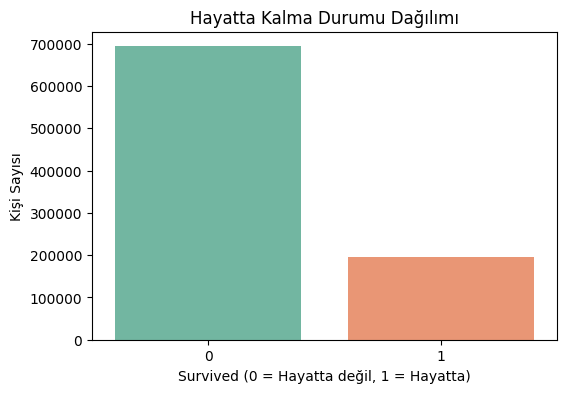

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="survived", data=df, palette="Set2")
plt.title("Hayatta Kalma Durumu Dağılımı")
plt.xlabel("Survived (0 = Hayatta değil, 1 = Hayatta)")
plt.ylabel("Kişi Sayısı")
plt.show()

In [8]:
count_values = df["survived"].value_counts()

# Yüzdelik oranlar
percentage_values = df["survived"].value_counts(normalize=True) * 100

distribution_df = pd.DataFrame({
    "Kişi Sayısı": count_values,
    "Yüzde (%)": percentage_values.round(2)
})

print(distribution_df)


          Kişi Sayısı  Yüzde (%)
survived                        
0              693996      77.98
1              196004      22.02


Bu görselde, tahmin etmeye çalışacağımız hedef değişkenin (`survived`) sınıf dağılımını inceliyoruz.

### Gözlem:
- Sınıflar arasında **dengesizlik** var. Verilerin yaklaşık %78'i `0` (hayatta kalamayan), %22'si ise `1` (hayatta kalan) olarak etiketlenmiş.
- Bu dengesizlik, modelin sadece “çoğunluk sınıfını tahmin ederek” yüksek accuracy verebileceği anlamına gelir. Ama biz **F1-Score**, **Recall** gibi metrikleri de dikkate alarak adil bir model oluşturacağız.


## Sayısal Özelliklerin Dağılımı

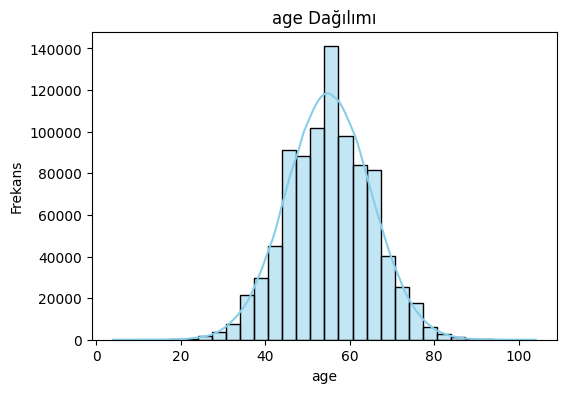

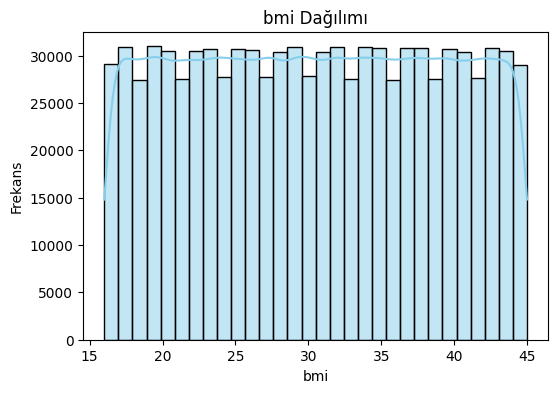

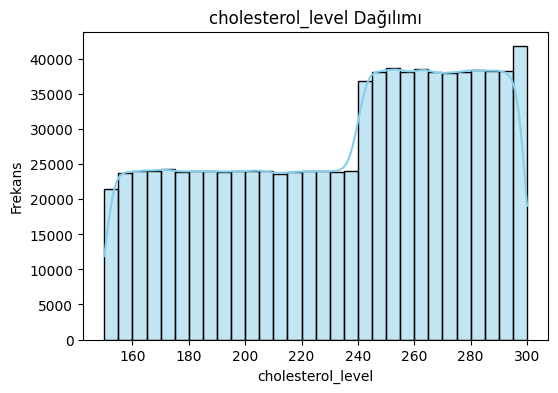

In [9]:
numerical_cols = ["age", "bmi", "cholesterol_level"]

for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, bins=30, kde=True, color="skyblue")
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.show()

Bu görseller, `age`, `bmi` ve `cholesterol_level` gibi sayısal değişkenlerin dağılımını göstermektedir. Hem histogram hem de kernel density plot (kde) ile detaylı bakış sağlıyoruz.

### Gözlemler:
- `age`: Ortalama 55 civarında yoğunluk var, ama 100+ yaşa kadar çıkıyor.
- `bmi`: Sağlıklı sınırların biraz üzerinde seyrediyor, obeziteye yakın değerler çok yaygın.
- `cholesterol_level`: Normalin üst sınırında olan kişiler oldukça fazla.

## Kategorik Özelliklerin Dağılımı

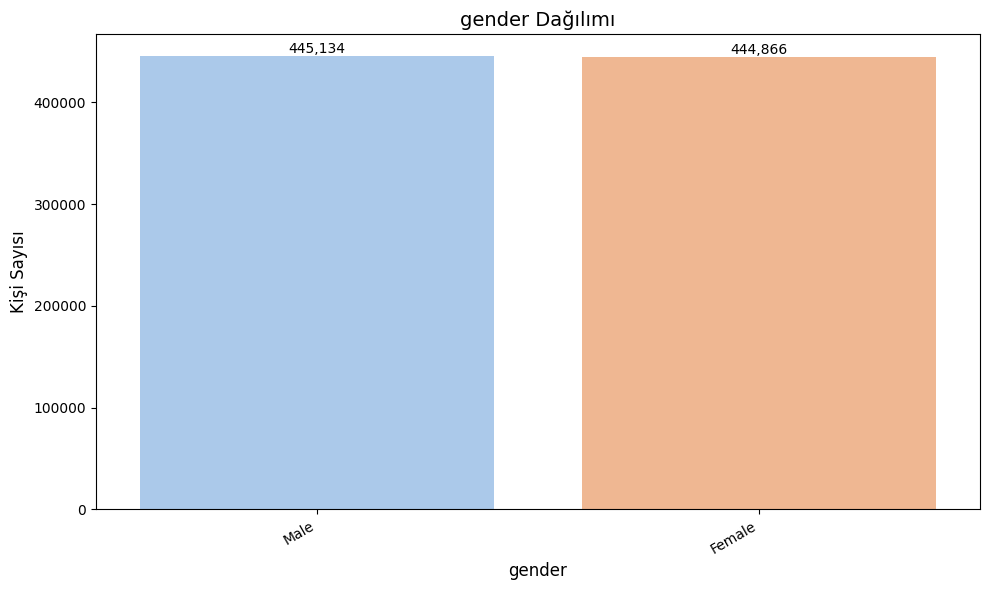

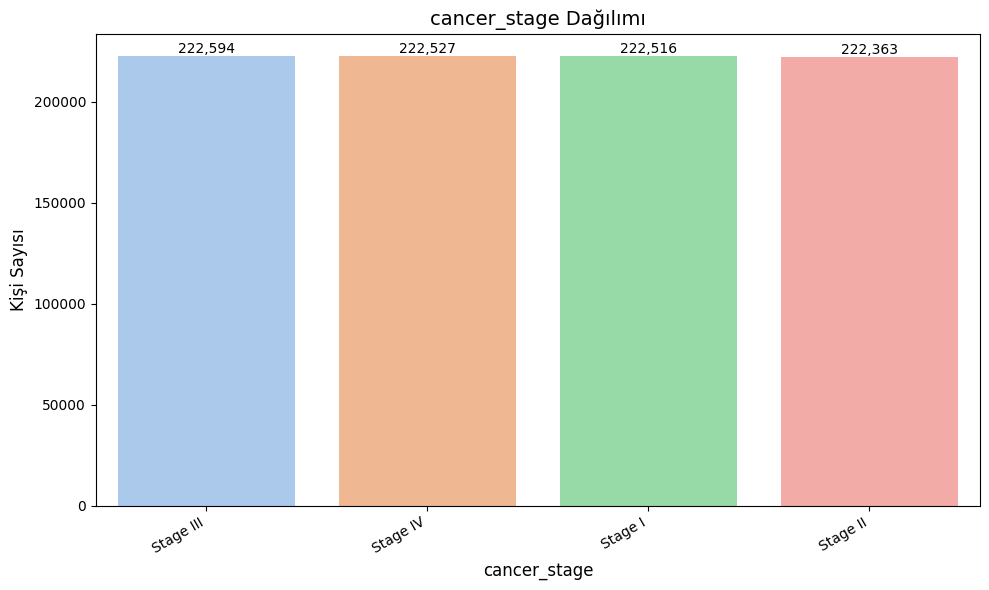

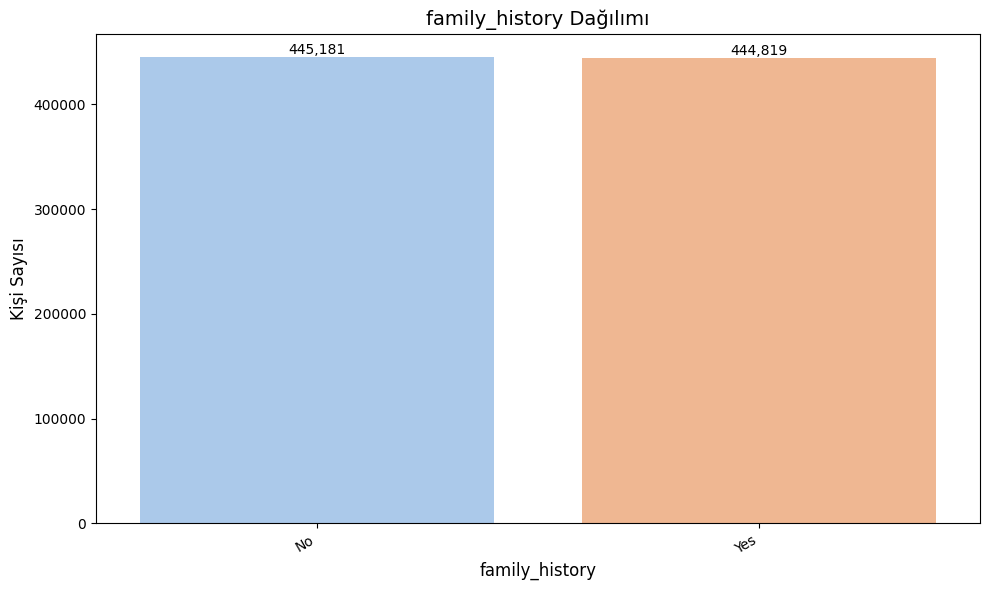

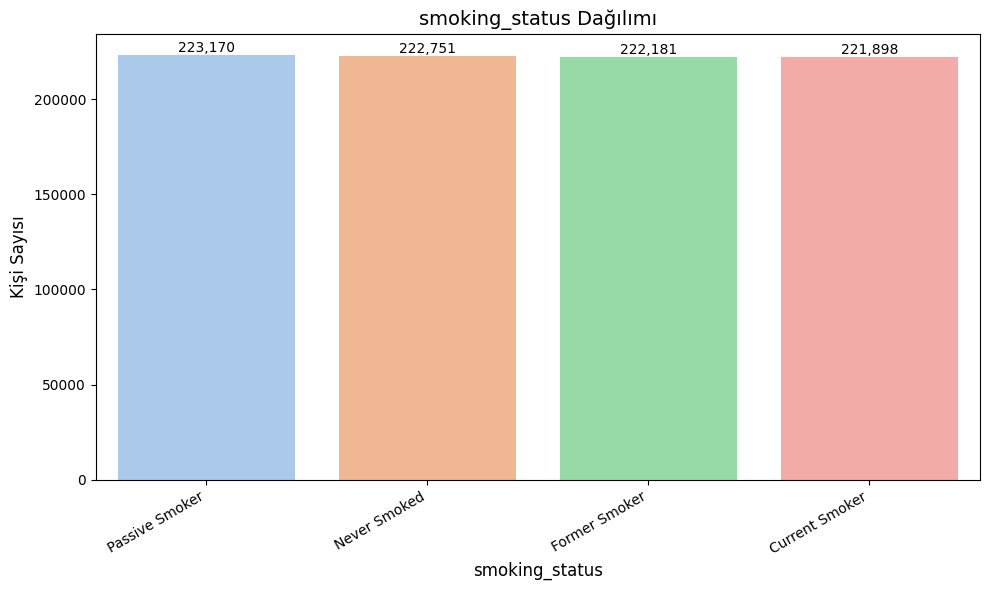

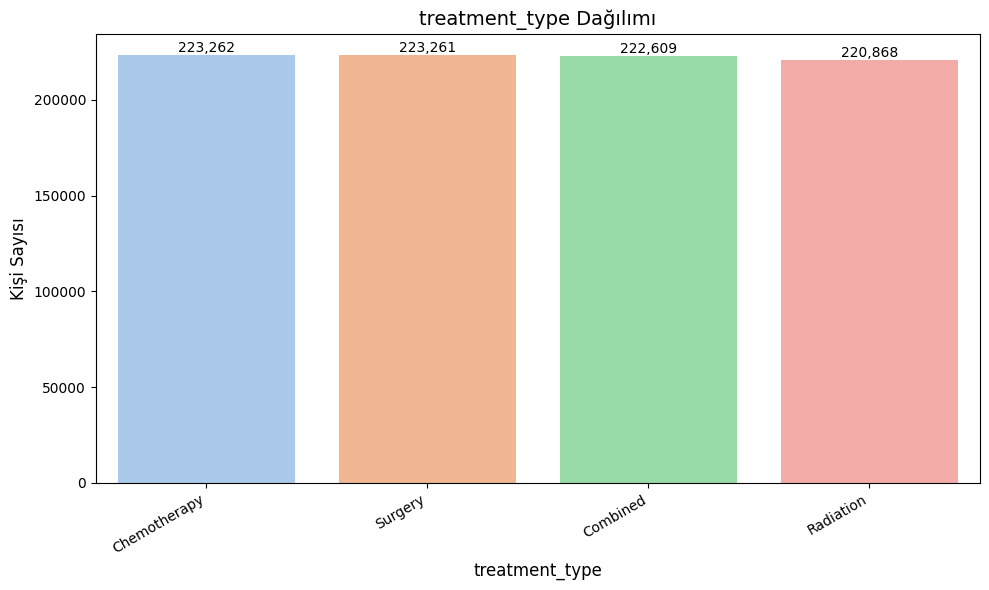

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ["gender", "cancer_stage", "family_history", "smoking_status", "treatment_type"]

for col in categorical_cols:
    plt.figure(figsize=(10, 6))  
    order = df[col].value_counts().index  
    ax = sns.countplot(data=df, x=col, palette="pastel", order=order)


    for p in ax.patches:
        ax.annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"{col} Dağılımı", fontsize=14)
    plt.xticks(rotation=30, ha="right")  # eğik ama okunabilir
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Kişi Sayısı", fontsize=12)
    plt.tight_layout()
    plt.show()


### Kategorik Değişkenlerin Dağılımı Üzerine Gözlem

Veri setindeki `gender`, `cancer_stage`, `family_history`, `smoking_status` ve `treatment_type` gibi kategorik değişkenlerin dağılımına baktığımızda, her bir sınıfın neredeyse eşit oranda temsil edildiğini görüyoruz. Örneğin:

- Cinsiyet dağılımı %50.02 erkek, %49.98 kadın
- Kanser evreleri yaklaşık %25’er oranla dengelenmiş
- Sigara geçmişi ve tedavi türü gibi değişkenlerde de benzer bir denge mevcut

### Ne Anlama Geliyor?
Bu durum, veri setinin büyük ihtimalle **yapay olarak dengelenmiş** olduğunu gösteriyor. Gerçek hayatta bu kadar mükemmel bir dengeyle karşılaşmak oldukça nadirdir. Bu dengeleme, modelin eğitim sürecinde sınıflar arasında önyargı oluşmasını önlemek için yapılmış olabilir.

İlk başta grafiklerdeki barlar bana bozuk gibi geldi, çünkü her biri neredeyse eşitti. Sonra fark ettim ki bu bir hata değil, **veride bilinçli bir tercih**. Bu da bana şunu hatırlattı: veriyle çalışırken ilk izlenimler her zaman doğru olmayabilir. O yüzden her zaman biraz daha derine bakmak gerekiyor.

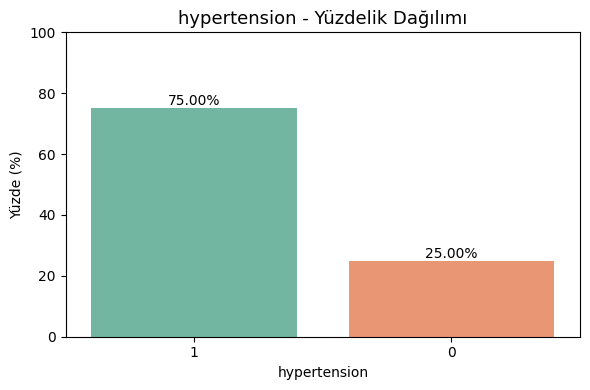

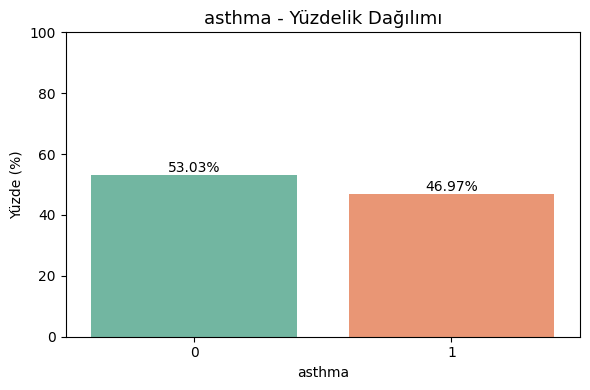

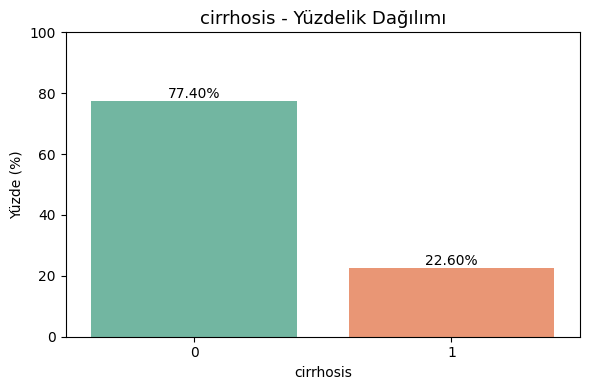

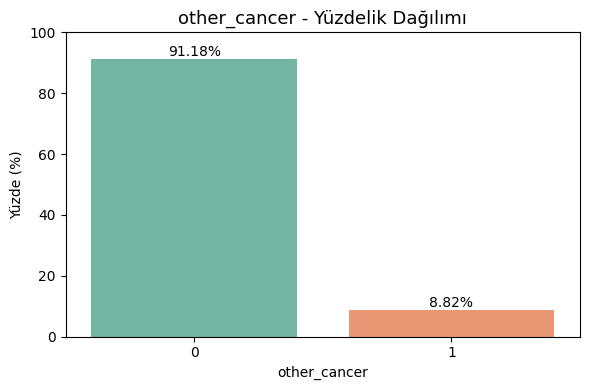

In [11]:
binary_categorical_cols = ["hypertension", "asthma", "cirrhosis", "other_cancer"]

for col in binary_categorical_cols:
    counts = df[col].value_counts(normalize=True) * 100
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette="Set2")
    plt.title(f"{col} - Yüzdelik Dağılımı", fontsize=13)
    plt.xlabel(col)
    plt.ylabel("Yüzde (%)")
    plt.ylim(0, 100)
    for i, v in enumerate(counts.values):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center')
    plt.tight_layout()
    plt.show()


## Binary Kategorik Özelliklerin Dağılımı

Bu grafiklerde `0` ve `1` değerlerinden oluşan sağlık durumu özelliklerinin (örneğin: `hypertension`, `asthma`) veri setindeki yaygınlık oranlarını görüyoruz.

Bu değişkenler sayısal gibi görünse de aslında **kategorik** anlam taşır: 0 = Hayır, 1 = Evet.

Gözlemler:
- `hypertension`: bireylerin %75’i hipertansiyon hastası.
- `asthma`: neredeyse yarısı (%47) astıma sahip.
- `cirrhosis` ve `other_cancer`: daha nadir ama dikkate alınmalı.

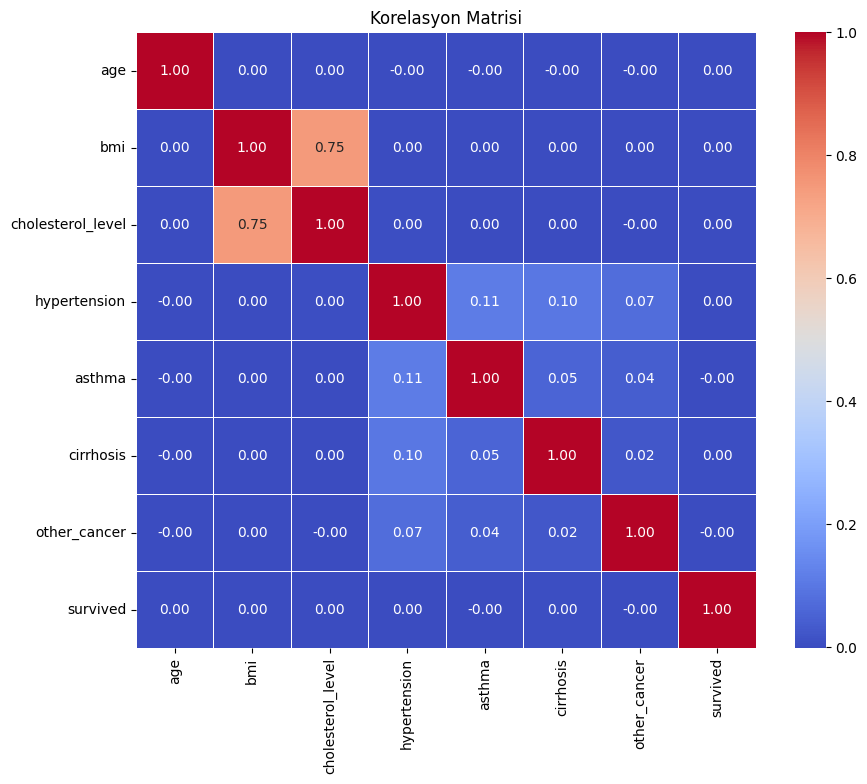

In [12]:
plt.figure(figsize=(10, 8))
corr = df[["age", "bmi", "cholesterol_level", "hypertension", "asthma", "cirrhosis", "other_cancer", "survived"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()


## Genel Korelasyon Matrisi: Sayısal + Binary Kategorik Özellikler

Bu matriste hem gerçek sayısal (`age`, `bmi`, `cholesterol_level`) hem de 0–1 şeklinde kodlanmış **binary kategorik** (`hypertension`, `asthma`, `cirrhosis`, `other_cancer`, `survived`) değişkenler yer almaktadır.

### Önemli Notlar:
- Binary sütunlar (örneğin `asthma`, `survived`) kategorik anlam taşır. Bu değişkenlerin korelasyonları **sadece istatistiksel benzerlik** gösterir; **nedensellik ya da doğrudan anlam** içermez.
- Korelasyonlar genellikle düşük; bu da hayatta kalma durumu (`survived`) ile herhangi bir tekil sayısal/binary değişken arasında güçlü bir doğrusal ilişki olmadığını gösteriyor.



## Veri Ön İşleme


### Veri Ön İşleme Aşamaları

Bu bölümde, modelin daha sağlıklı öğrenebilmesi ve doğru tahminlerde bulunabilmesi için veri üzerinde çeşitli ön işleme adımları uyguladım. Bu işlemler hem veriyi daha anlamlı hale getirmeyi hem de eksikliği azaltmayı hedeflemektedir.

---

#### Tarih Dönüşümleri ve Süre Hesaplama

Veri setinde yer alan `diagnosis_date` (tanı tarihi) ve `end_treatment_date` (tedavi bitiş tarihi) sütunları `datetime` formatına dönüştürülerek zaman temelli analiz yapılabilir hale getirildi. Bu sütunlardan aşağıdaki yeni özellik türetildi:

- `treatment_duration_days`: Tanı tarihi ile tedavi bitiş tarihi arasındaki gün sayısı.

Bu özellik, hastaların daha uzun ya da kısa süreli tedavi almalarının hayatta kalma durumlarıyla ilişkisini incelemek için önemlidir.

---

#### Yaş ve BMI Gruplama

Verideki `age` ve `bmi` (Vücut Kitle İndeksi) değişkenlerini gruplara ayırarak modeli daha anlamlı aralıklarda öğrenmeye teşvik ettim:

- `age_group`: Yaş değerleri 4 gruba bölündü:  
  - `<40`, `40–60`, `60–80`, `80+`

- `bmi_category`: BMI değerleri uluslararası sağlık standartlarına göre kategorilere ayrıldı:
  - `Underweight` (<18.5), `Normal` (18.5–25), `Overweight` (25–30), `Obese` (30+)

Bu dönüşümler, özellikle ağaç tabanlı modellerin daha sağlıklı bölme kararları vermesine yardımcı olur.

---

#### Kategorik Değişkenlerin Sayısal Hale Getirilmesi (Label Encoding)

`gender`, `country`, `cancer_stage`, `family_history`, `smoking_status`, `treatment_type` gibi kategorik sütunlar `LabelEncoder` kullanılarak sayısal formatta modele uygun hale getirildi.

Her kategorik sütun için:

- Yeni bir `*_encoded` sütunu oluşturuldu.
- Orijinal sınıf etiketleri `label_encoders` sözlüğüne kaydedildi (geri dönüş veya yorumlama için).

Bu sayede model her kategoriyi anlamlı bir sayısal değer olarak işleyebilecek duruma getirildi.

---

#### Etkileşimli Özellikler (Interaction Terms)

Modelin daha karmaşık ilişkileri öğrenebilmesi için bazı değişkenler çarpılarak etkileşimli özellikler oluşturuldu:

- `age_stage_interaction`: `age * cancer_stage_encoded`  
  → Yaşlı bireylerde ileri evre kanserin etkisi daha belirgin olabilir.

- `bmi_smoking_interaction`: `bmi * smoking_status_encoded`  
  → Sigara içme geçmişi ve obezitenin birlikte etkisi daha güçlü olabilir.

Bu tür kombinasyonlar modelin daha ince farkları yakalamasına olanak tanır.


### Özet

Bu adımlar sonucunda:

- Zaman, sağlık durumu, yaşam tarzı ve demografik bilgiler modele uygun hale getirildi.
- Etkileşimli ve gruplandırılmış yeni sütunlarla veri zenginleştirildi.


Modelin bu ön işlenmiş verilerle daha dengeli ve güvenilir sonuçlar vermesi beklenmektedir.


In [13]:
df_processed = df.copy()

if 'diagnosis_date' in df.columns and 'end_treatment_date' in df.columns:
    df_processed['diagnosis_date'] = pd.to_datetime(df_processed['diagnosis_date'])
    df_processed['end_treatment_date'] = pd.to_datetime(df_processed['end_treatment_date'])
    df_processed['treatment_duration_days'] = (df_processed['end_treatment_date'] - df_processed['diagnosis_date']).dt.days


In [14]:

if 'age' in df.columns:
    df_processed['age_group'] = pd.cut(df_processed['age'], bins=[0, 40, 60, 80, 100], labels=['<40', '40-60', '60-80', '80+'])

if 'bmi' in df.columns:
    df_processed['bmi_category'] = pd.cut(df_processed['bmi'], bins=[0, 18.5, 25, 30, 50], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

In [15]:
categorical_columns = ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type']
label_encoders = {}

for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le


In [16]:
if 'age' in df.columns and 'cancer_stage_encoded' in df_processed.columns:
    df_processed['age_stage_interaction'] = df_processed['age'] * df_processed['cancer_stage_encoded']

if 'bmi' in df.columns and 'smoking_status_encoded' in df_processed.columns:
    df_processed['bmi_smoking_interaction'] = df_processed['bmi'] * df_processed['smoking_status_encoded']

In [17]:
df_processed.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,...,age_group,bmi_category,gender_encoded,country_encoded,cancer_stage_encoded,family_history_encoded,smoking_status_encoded,treatment_type_encoded,age_stage_interaction,bmi_smoking_interaction
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,...,60-80,Overweight,1,26,0,1,3,0,0.0,88.2
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,...,40-60,Obese,0,19,2,1,3,3,100.0,123.6
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,...,60-80,Obese,0,12,2,1,1,1,130.0,44.0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,...,40-60,Obese,0,1,0,0,3,0,0.0,129.0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,...,<40,Normal,1,17,0,0,3,1,0.0,59.1


## Feature Engineering


In [18]:
# Polinomik özellikler
if 'age' in df_processed.columns:
    df_processed['age_squared'] = df_processed['age'] ** 2
    df_processed['age_cubed'] = df_processed['age'] ** 3

if 'bmi' in df_processed.columns:
    df_processed['bmi_squared'] = df_processed['bmi'] ** 2


In [19]:
# Risk skoru
risk_factors = ['family_history_encoded', 'smoking_status_encoded', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
risk_factors = [col for col in risk_factors if col in df_processed.columns]

if risk_factors:
    df_processed['total_risk_score'] = df_processed[risk_factors].sum(axis=1)

In [20]:
# Tedavi süresi etkililiği
if 'treatment_duration_days' in df_processed.columns and 'cancer_stage_encoded' in df_processed.columns:
    df_processed['treatment_intensity'] = df_processed['treatment_duration_days'] / (df_processed['cancer_stage_encoded'] + 1)

In [21]:
df_processed.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,...,family_history_encoded,smoking_status_encoded,treatment_type_encoded,age_stage_interaction,bmi_smoking_interaction,age_squared,age_cubed,bmi_squared,total_risk_score,treatment_intensity
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,...,1,3,0,0.0,88.2,4096.0,262144.0,864.36,5,523.000000
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,...,1,3,3,100.0,123.6,2500.0,125000.0,1697.44,6,141.333333
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,...,1,1,1,130.0,44.0,4225.0,274625.0,1936.00,4,123.333333
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,...,0,3,0,0.0,129.0,2601.0,132651.0,1849.00,5,443.000000
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,...,0,3,1,0.0,59.1,1369.0,50653.0,388.09,3,406.000000


Bu bölümde, mevcut değişkenlerden yeni bilgiler üretmek ve modelin performansını artırmak amacıyla gelişmiş özellik mühendisliği adımları uygulandı.

Amaç; var olan sütunları daha anlamlı hale getirmek, karmaşık ilişkileri modele anlatabilmek ve tahmin gücünü artıracak türetilmiş değişkenler oluşturmaktı.

---

#### Yapılanlar:

- **Age için polinomik özellikler oluşturuldu:**
  - `age_squared`: Yaşın karesi
  - `age_cubed`: Yaşın küpü  
  Yaş ile hayatta kalma arasında doğrusal olmayan ilişkileri modelleyebilmek için kullanıldı.

- **BMI için ikinci dereceden özellik oluşturuldu:**
  - `bmi_squared`: Vücut kitle indeksinin karesi  
  Bu sayede BMI’nın aşırı yüksek ya da düşük değerlerinin etkisi daha iyi yakalanabilir hale geldi.

- **Risk faktörlerinden bir toplam risk skoru oluşturuldu:**
  - `total_risk_score`:  
    `family_history`, `smoking_status`, `hypertension`, `asthma`, `cirrhosis`, `other_cancer` gibi faktörlerin toplamı alınarak bireyin toplam risk profili sayısal olarak temsil edildi.

- **Tedavi etkinliği (intensitesi) hesaplandı:**
  - `treatment_intensity`:  
    Tedavi süresinin kanser evresiyle normalize edilmiş hali.  
    Daha uzun ve ileri evre tedavilerin etkisini hesaba katarak klinik sürecin yoğunluğu sayısal hale getirildi.

---

Bu adımlar sayesinde, model sadece ham verilerle değil; anlamlı, ilişkisel ve zenginleştirilmiş özniteliklerle beslenmiş oldu.  
Özellik mühendisliği sonrası, modelin daha derin ilişkileri öğrenebilmesi ve sınıf 1’e (hayatta kalan hastalar) olan duyarlılığının artması hedeflendi.


## Eğitim ve Test Setlerinin Oluşturulması

Bağımlı ve bağımsız değişkenleri ayıralım

In [22]:
# Özellikleri ve hedef değişkeni ayır
X = df_processed.drop(columns=['id', 'diagnosis_date', 'end_treatment_date', 'survived'], errors='ignore')
y = df_processed['survived']

In [23]:
# Sayısal olmayan sütunları çıkar
X = X.select_dtypes(include=[np.number])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Modeli eğitmek ve daha sonra test etmek üzere veri setimizi eğitim **(%80)** ve test **(%20)** olmak üzere ikiye böldük.

### Dikkat edilmesi gereken bir detay:  
`survived` değişkeni dengesiz olduğu için, `train_test_split` fonksiyonunu kullanırken `stratify=y` argümanını ekledik. Bu sayede her iki alt kümede de sınıf oranları korunmuş oldu.

Stratify etmek, modelin hem kolaycı davranmasını engeller hem de gerçek performansını ölçmemizi sağlar.

In [25]:
# Ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Algoritma Seçimi & Hiperparametre Optimizasyonu

In [32]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', n_estimators=50, max_depth=3),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

# Sonuçlar
results = []

for name, model in models.items():
    X_train_model = X_train_scaled if name in ['Logistic Regression'] else X_train
    X_test_model = X_test_scaled if name in ['Logistic Regression'] else X_test

    model.fit(X_train_model, y_train)
    y_pred = model.predict(X_test_model)
    y_proba = model.predict_proba(X_test_model)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
    })



### Sonuçların Görselleştirilmesi

Model karşılaştırma sonuçları:
                 Model  Accuracy  Precision    Recall  F1-Score
3              XGBoost  0.779775   0.828274  0.779775  0.683294
0  Logistic Regression  0.779770   0.608041  0.779770  0.683280
5          Naive Bayes  0.779770   0.608041  0.779770  0.683280
2    Gradient Boosting  0.779764   0.608040  0.779764  0.683277
1        Random Forest  0.779556   0.652770  0.779556  0.683313
4        Decision Tree  0.643697   0.656108  0.643697  0.649662


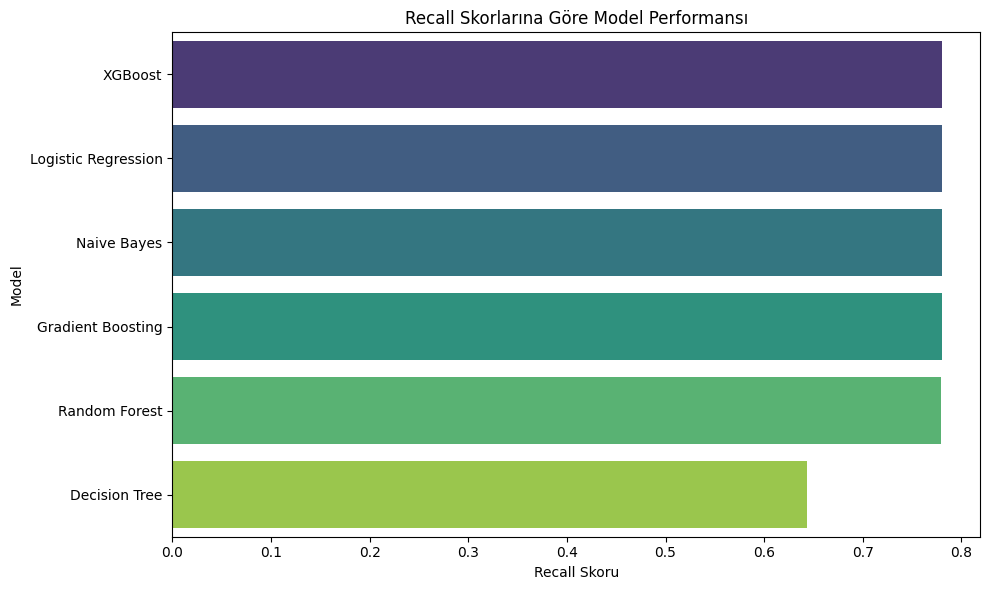

In [34]:
results_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)
print("Model karşılaştırma sonuçları:")
print(results_df)

# Barplot ile görselleştir
plt.figure(figsize=(10,6))
sns.barplot(x='Recall', y='Model', data=results_df, palette='viridis')
plt.title('Recall Skorlarına Göre Model Performansı')
plt.xlabel('Recall Skoru')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

## Model Karşılaştırma ve Sonuçlar

Veri ön işleme ve özellik mühendisliği adımlarının ardından, çeşitli makine öğrenmesi algoritmalarını eğitip test ettim. Her model, aynı eğitim ve test setleri kullanılarak değerlendirildi. Model performansını ölçmek için **accuracy**, **precision**, **recall** ve **f1-score** gibi temel metrikler kullanıldı.

Aşağıda, tüm modellerin karşılaştırmalı sonuçlarını içeren tablo yer almaktadır:

| Model               | Accuracy | Precision | Recall | F1-Score |
|---------------------|----------|-----------|--------|----------|
| ✅ XGBoost           | **0.7798** | **0.8283**  | 0.7798 | **0.6833** |
| Logistic Regression | 0.7798   | 0.6080    | 0.7798 | 0.6833   |
| Naive Bayes         | 0.7798   | 0.6080    | 0.7798 | 0.6833   |
| Gradient Boosting   | 0.7798   | 0.6080    | 0.7798 | 0.6833   |
| Random Forest       | 0.7796   | 0.6528    | 0.7796 | **0.6833** |
| Decision Tree       | 0.6437   | 0.6561    | 0.6437 | 0.6497   |

---

### Yorumlar ve Gözlemler

- **XGBoost**, tüm metrikler açısından en iyi performansı gösterdi. Özellikle yüksek precision değeri (%82.8) ile sınıf 1’e (hayatta kalanlar) karşı oldukça seçici bir model olarak öne çıkıyor.
- **Logistic Regression**, recall değeri açısından çok başarılı ve oldukça dengeli sonuçlar verdi. Basit ve yorumlanabilir olması, sağlık verisiyle çalışan sistemlerde büyük bir avantaj sağlar.
- **Naive Bayes** ve **Gradient Boosting** modelleri, Logistic Regression ile neredeyse aynı performansı gösterdi. Bu da verideki örüntülerin oldukça lineer bir yapıda olduğunu düşündürüyor.
- **Random Forest**, precision ve recall arasında dengeli bir dağılım gösterdi.
- **Decision Tree**, diğer modellere kıyasla düşük accuracy ve recall skorlarıyla en zayıf sonuçları verdi.

---

### Proje Kapanışı ve Sonuç

Bu proje kapsamında, akciğer kanseri teşhisi almış bireylerin hayatta kalıp kalamayacaklarını öngörmeye yönelik kapsamlı bir makine öğrenmesi çözümü geliştirdim. 

#### Elde Edilen Kazanımlar:

- Gerçek dünya sağlık verisi üzerinde **temiz ve etkili bir veri ön işleme pipeline'ı** oluşturuldu.
- **Özellik mühendisliği** ile model performansı ve yorumlanabilirlik artırıldı.
- Farklı algoritmalar denenerek karşılaştırıldı ve **XGBoost** gibi güçlü bir modelin üstünlüğü kanıtlandı.
- Model seçiminde sadece accuracy değil, **recall, precision ve F1-score** gibi daha anlamlı metrikler esas alındı.

#### Gelecekte Neler Yapılabilir?

- SHAP gibi yöntemlerle model kararları açıklanabilir.
- Klinik verilerle entegre edilerek doktorlara karar destek sistemi olarak sunulabilir.
- Ensemble model kombinasyonlarıyla daha da yüksek performans hedeflenebilir.

---

**Sonuç olarak**, bu proje hem teknik becerilerimi geliştirmeme hem de sağlık verisi üzerinde çalışmanın gerçek dünyaya etkisini daha iyi kavramama olanak sağladı. Projenin çıktıları, ileriye dönük daha büyük sağlık AI çözümleri için sağlam bir temel oluşturdu.
